# BE 521 Final Project
University of Pennsylvania BE 521 Brain-Computer Interface, Spring 2024

Team: Van Leeuwen

Members: Celine Lee, Sabrina Weng


# Project Overview

This final project aimed to predict finger flexion using intracranial EEG (ECoG) in three human subjects. The data and problem framing come from the 4th BCI Competition (Miller et al. 2008). This project proposed using ensemble modeling of XGBoost and AdaBoost for regression to train the preprocessed ECoG signal. The final correlation score achieved 0.4717 on the leaderboard. The detail of the code is as below.


# 1. Getting Started

In [ ]:
# Import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, sosfiltfilt
from scipy.io import savemat

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

## Data Analysis


**Data Description**

The file 'raw_training_data.mat' consists of 2 datasets, train_ecog and train_dg.

- The np.ndarray shapes for 'train_ecog' are (m x 62), (m x 48), and (m x 64), where m is the number of samples in the signal, and each subject had 62, 46, and 64 ecog channels, respectively.

- All np.ndarray shapes for 'train_dg' should be (m x 5), where m is the number of samples in the signal, and 5 is the number of fingers.

- In this dataset, there are 300000 samples of training datasets. (m = 300000)

- The sampling rate in this case is set to 1000 Hz.

The file 'leaderboard_data.mat' is the testing ecog dataset, including 1 dataset 'leaderboard_ecog' and we define as test_ecog.
- The np.ndarray shapes for 'test_ecog' are (m x 62), (m x 48), and (m x 64), where m is the number of samples in the signal, and each subject had 62, 46, and 64 ecog channels, respectively.
- In this testing dataset, there are 147500 samples. (m = 147500)

In [ ]:
# Load training and leader board data
train_data = loadmat('raw_training_data.mat')
leaderboard = loadmat('leaderboard_data.mat')

ecog = train_data['train_ecog'] # (3, 1)
dg = train_data['train_dg'] # (3, 1)

leaderboard_ecog = leaderboard['leaderboard_ecog'] # (3, 1)

# Clean up data
train_ecog = [ecog[i][0] for i in range(len(ecog))] # (3)(300000, x)
train_dg = [dg[i][0] for i in range(len(ecog))] # (3)(300000, 5)

In [ ]:
# Split into train set and validation set
train_dg, val_dg, train_ecog, val_ecog = [], [], [], []

for i in range(len(ecog)):
  g_train, g_val, e_train, e_val = train_test_split(dg[i][0], ecog[i][0], test_size=0.25, random_state=42, shuffle = False)
  train_dg.append(g_train)
  val_dg.append(g_val)
  train_ecog.append(e_train)
  val_ecog.append(e_val)

print(f'Spliting {len(ecog[0][0])} datset into {len(g_train)} training sets, and {len(g_val)} validation sets.')

Spliting 300000 datset into 225000 training sets, and 75000 validation sets.


# 2. Data Preprocessing



## Filter function
Implement the `filter_data` function to clean underlying data. We used a bandpass filter with a low cutoff frequency of 0.15 Hz and a high cutoff frequency of 200 Hz. The sampling is set to 1000 Hz in this dataset and the order is set to 4.

In [ ]:
def filter_data(data, pass_band=(0.15, 200), fs=1000, order=4):
    """
    Input:
      data (samples x channels): the raw (noisy) signal
      fs: the sampling rate (1000 for this dataset)
    Output:
      clean_data (samples x channels): the filtered signal
    """
    sos = sig.butter(order, Wn=pass_band, btype="bandpass", fs=fs, output="sos")
    if len(data.shape) > 1:
        clean_data = np.array([sig.sosfiltfilt(sos, eeg) for eeg in data.T]).T
    else:
        clean_data = sig.sosfiltfilt(sos, data)

    # assert clean_data.shape == data.shape
    return clean_data

## Number of Windows Calculation Function
Calculate the number of windows `m`. In this case, we set the window length of 100ms and 50ms window overlap/window displacement.

In [ ]:
# Define parameters
fs = 1000 # (Hz)
winLen = 100e-3 # (s)
winDisp = 50e-3 # (s)
length = winLen * fs
displacement = winDisp * fs

# Define the function for calculating number of window
def NumWins(x, fs, length, displacement):
    return (len(x) - length)/displacement  + 1

# Calculate number of windows
M = NumWins(train_ecog[0], fs, length, displacement)
print('There will be',M,'feature windows.')

There will be 4499.0 feature windows.


## Get features function

Implement the `get_features` function to calculate features for a given filtered window from the ECoG signal for better training. We utilized various methods and extracted 9 different features, including:
1. Average time-domain voltage
2. Hjorth Activity
3. Hjorth Mobility
4. Hjorth Complexity
5. Power spectrum with bandwidth range 12-30 Hz (Alpha)
6. Power spectrum with bandwidth range 30-70 Hz (Beta)
7. Power spectrum with bandwidth range 70-150 Hz (Gamma)
8. Zero Crossings
9. Absolute Sum of Differences






In [ ]:
num_features = 9

def fn_zero_crossings(x):
        x_cent = x - np.mean(x, axis=0)
        x_shift = np.hstack([x_cent[:, 1:], x_cent[:, -1].reshape((-1, 1))])
        x_cross = (x_cent * x_shift) < 0
        return np.sum(x_cross, axis=0)

# Update the function definition
def get_features(filtered_window, fs=1000):
    """
    Input:
        filtered_window (window_samples x channels): the window of the filtered ecog signal
        fs: sampling rate
    Output:
        features (channels x num_features): the features calculated on each channel for the window
    """
    features = np.zeros((len(filtered_window[0]), num_features))

    # Feature 1: Average time-domain voltage
    features[:,0] = np.mean(filtered_window, axis=0)

    # Feature 2-4: Hjorth parameters
    # Hjorth Activity
    features[:,1] = np.var(filtered_window, axis=0)
    # Hjorth Mobility
    first_derivative  = np.diff(filtered_window, axis=0)
    features[:,2] = np.sqrt(np.var(first_derivative, axis=0) / np.var(filtered_window, axis=0))
    # Hjorth Complexity
    features[:,3] = np.sqrt(np.var(np.diff(first_derivative, axis=0)) / np.var(first_derivative, axis=0))


    # Feature 5-7: Power spectrum with different bandwidth range
    freqs, psd = sig.welch(filtered_window, fs=fs, axis=0, nperseg = 100)
    # Alpha (12-30 Hz)
    features[:,4] = np.mean(psd[(freqs >= 12) & (freqs <= 30)], axis=0)
    # Beta (30-70 Hz)
    features[:,5] = np.mean(psd[(freqs >= 30) & (freqs <= 70)], axis=0)
    # Gamma (70-150 Hz)
    features[:,6] = np.mean(psd[(freqs >= 70) & (freqs <= 150)], axis=0)

    # Feature 8: Zero Crossings
    features[:,7] = fn_zero_crossings(filtered_window)

    # Feature 9: Absolute Sum of Differences
    features[:,8] = np.sum(np.absolute(np.diff(filtered_window, axis=0)), axis=0)

    return features

## Get window feature function
Implement the `get_windowed_feats` function to processes data through the steps of filtering (`filter_data`) and feature calculation (`get_features`) to return a feature vector for each time window.

In [ ]:
def get_windowed_feats(raw_ecog, fs, window_length, window_overlap):
    """
    Inputs:
        raw_eeg (samples x channels): the raw signal
        fs: the sampling rate (1000 for this dataset)
        window_length: the window's length
        window_overlap: the window's overlap
    Output:
        all_feats (num_windows x (channels x features)): the features for each channel for each time window
        note that this is a 2D array.
    """
    # Filter the raw ecog signal
    filtered_ecog = filter_data(raw_ecog, fs=fs)

    # Calculate number of windows
    M = NumWins(filtered_ecog, fs, window_length, window_overlap)

    # Initialize output array
    num_channels = len(filtered_ecog[0])
    num_feature = num_features
    all_feats = np.zeros((int(M), num_channels * num_feature))

    for n in range(int(M)):
        start = int(n * window_overlap)
        end = start + int(window_length)
        filtered_window = filtered_ecog[start:end]

        # Calculate and store features of each window
        all_feats[n, :] = get_features(filtered_window).flatten()

    return all_feats

## Create R matrix function
Implement the `create_R_matrix` function to calculate the R matrix. Also include appending a copy of the first N-1 rows of your feature matrix to the beginning of the feature matrix.

In [ ]:
def create_R_matrix(features, N_wind):
  """
  Input:
    features (samples (number of windows in the signal) x channels x features):
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

  Output:
    R (samples x (N_wind*channels*features))
  """
  # Append first N-1 to the beginning of feature array
  features_adjusted = np.concatenate([features[:2,:], features], axis=0)

  # Initialization of response matrix
  num_rows = len(features)
  num_cols = len(features[0]) * N_wind + 1
  num_features = 9
  num_channels = int(len(features[0])/num_features)
  R = np.zeros((num_rows, num_cols))

  for i in range(num_rows):
    # Append one to the beginning of each row
    R[i,0] = 1

    for j in range(num_channels):
      start_col = j * num_features * N_wind + 1
      end_col = start_col + num_features * N_wind

      start_index = j * num_features
      end_index = start_index + num_features

      R[i, start_col:end_col] = features_adjusted[i:i+N_wind, start_index:end_index].flatten()

  return R

# 3. ML Training and Validation Evaluation

## Training and Validation Dataset Feature Preparation

In [ ]:
# Create feature matrix for the training dataset
train1_features = get_windowed_feats(train_ecog[0], fs, length, displacement)
train2_features = get_windowed_feats(train_ecog[1], fs, length, displacement)
train3_features = get_windowed_feats(train_ecog[2], fs, length, displacement)

all_train_features = [train1_features, train2_features, train3_features]

# Create feature matrix for the validation dataset
val1_features = get_windowed_feats(val_ecog[0], fs, length, displacement)
val2_features = get_windowed_feats(val_ecog[1], fs, length, displacement)
val3_features = get_windowed_feats(val_ecog[2], fs, length, displacement)

all_val_features = [val1_features, val2_features, val3_features]

# Downsampling of data glove
all_glove = []
for i, data in enumerate(train_dg):
  factor = int(len(data)/all_train_features[0].shape[0])
  all_glove.append(data[::factor][:all_train_features[0].shape[0]])

In [ ]:
# Define function for interpolate predictions
def cubic_interp(predictions, desired_length):
    interpolated = []

    for filter in predictions:
        original_time = np.arange(0, len(filter)) * winDisp

        # Create a cubic spline interpolation object
        cubic_spline = CubicSpline(original_time, filter)

        new_time = np.linspace(0, original_time[-1], desired_length)

        # Interpolate the filter coefficients at the new time points
        interpolated.append(cubic_spline(new_time))

    return interpolated

In [ ]:
# Create R matrix for training features
R1_train = create_R_matrix(train1_features, 3)
R2_train = create_R_matrix(train2_features, 3)
R3_train = create_R_matrix(train3_features, 3)
R_train = [R1_train, R2_train, R3_train]

# Create R matrix for validation features
R1_val = create_R_matrix(val1_features, 3)
R2_val = create_R_matrix(val2_features, 3)
R3_val = create_R_matrix(val3_features, 3)
R_val = [R1_val, R2_val, R3_val]

print(f'Including {len(R_train[0])} training features, and {len(R_val[0])} validation features.')

Including 4499 training features, and 1499 validation features.


## Proposed Training Model: Ensemble Modeling of XGBoost and AdaBoost Regressor

Train the XGBoost model and AdaBoost Regressor using the calculated R matrix of 4,499 training features, respectively, instead of training the total of 225,000 training sets.

In [ ]:
# Initialization
all_xgb_model = []
all_ada_model = []

# Train the XGBoost model and AdaBoost Regressor
for glove, train_feature in zip(all_glove, R_train):

    xgb_model_subj = []
    ada_model_subj = []

    for i in tqdm(range(len(train_dg[0][0]))):
        y_glove = glove[:,i].flatten()

        # Initialize and train on the data
        xgb_model = xgb.XGBRegressor()
        ada_model = AdaBoostRegressor(n_estimators = 100)

        # Train the model
        xgb_model.fit(train_feature, y_glove)
        ada_model.fit(train_feature, y_glove)

        # Append the model
        xgb_model_subj.append(xgb_model)
        ada_model_subj.append(ada_model)

    # Append the model
    all_xgb_model.append(xgb_model_subj)
    all_ada_model.append(ada_model_subj)


100%|██████████| 5/5 [21:28<00:00, 257.75s/it]


Test the XGBoost model and AdaBoost Regressor using the calculated R matrix of a total of 1,499 validation features, respectively.
Then, ensemble the two models by calculating the mean of the validation result. Lastly, interpolate the result to expand back to the full 75,000 validation sets.

In [ ]:
Y_val = []

# test the validation set and ensemble the models
for i, features in tqdm(enumerate(R_val)):
    Y_temp = []
    # Using trained model
    for finger in range(len(all_xgb_model[0])):

        # Ensemble
        xgb_pred = all_xgb_model[i][finger].predict(features)
        ada_pred = all_ada_model[i][finger].predict(features)
        Y_temp.append(np.mean([xgb_pred, ada_pred], axis=0))

    # Store the predicted value in 3x5
    Y_val.append(np.array(Y_temp).T)

# Interpolate
interpolated_Y = cubic_interp(Y_val, len(val_ecog[0]))

3it [00:11,  3.75s/it]


## Save the models with Pickle

In [ ]:
import pickle

pickle.dump(all_xgb_model, open('xgb_model.pkl', 'wb'))
pickle.dump(all_xgb_model, open('ada_model.pkl', 'wb'))

## Data Post-processing

This section performs post-processing on the predicted data. We first plot the true target data along with the interpolated data that was not post-processed. We can see that there are lots of noise in the predicted interpolated data, therefore, we want to employ some post-processing techniques on the predicted data.

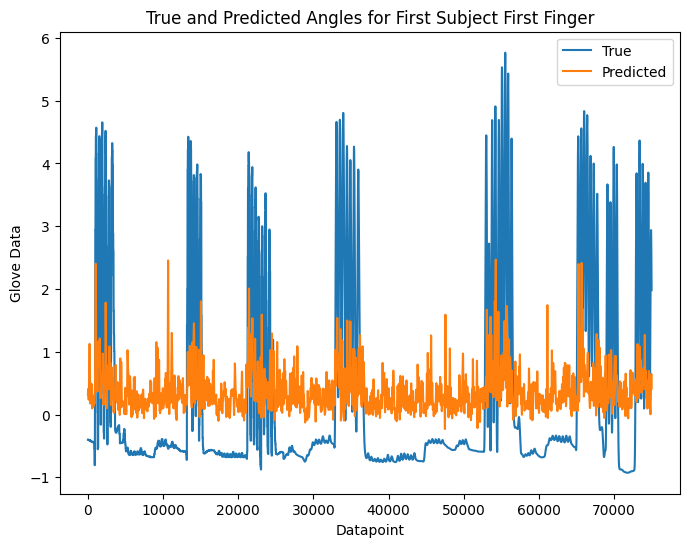

In [ ]:
# Plot to see predicted and true finger difference
fs = 1000 # (Hz)
t = np.arange(0,len(val_dg[0]),1/fs)
plt.figure(figsize=(8,6))
plt.plot(val_dg[0][:,0], label='True')
plt.plot(interpolated_Y[0][:,0], label='Predicted')
plt.title('True and Predicted Angles for First Subject First Finger')
plt.xlabel('Datapoint')
plt.ylabel('Glove Data')
plt.legend();

Here we formulate a weighted moving average function that takes in the input data and weights, and it applies the moving average filter through convolution, and the function returns a smoothed data. The input data being passed to this function will be the predicted glove data.

In [ ]:
# Weighted moving average function
def moving_average(data, weights = [0.2, 0.3, 0.5]):
    """
    Apply a moving average filter to the input data.

    Parameters:
    - data: Input data (1D array-like)
    - weights: Different weights to be applied

    Returns:
    - smoothed_data: Data after applying the moving average filter (1D array)
    """
    # Pad the data at both ends to handle edge cases
    padded_data = np.pad(data, (len(weights) // 2, len(weights) // 2), mode='edge')

    # Apply the weighted moving average filter
    smoothed_data = np.convolve(padded_data, weights[::-1], mode='valid')

    return smoothed_data

Now we defined our weighted moving average function, we can implement it along with the prediction. The following section uses the trained XGBoost and AdaBoost models to predict on the R matrix of validation set. Then, the predicted glove data is passed through the weighted moving average function for post-processing. The post-processed predictions are then interpolated to match the shape of true glove data. The plot below demonstrates the true glove data along with post-processed interpolated predictions of glove data.

3it [00:06,  2.31s/it]


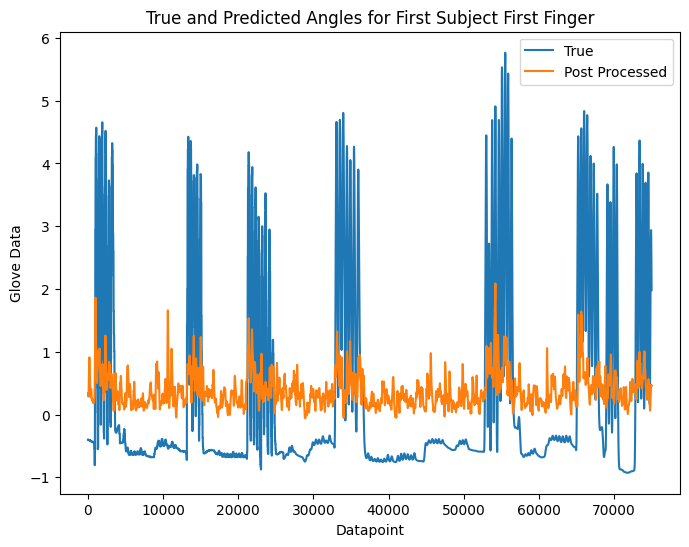

In [ ]:
# Post-processing
Y_test, Y_post = [], []

for i, features in tqdm(enumerate(R_val)):
    Y_temp, Y_moving = [], []
    for finger in range(len(all_ada_model[0])):
        # Predict using the model
        xgb_pred = all_xgb_model[i][finger].predict(features)
        ada_pred = all_ada_model[i][finger].predict(features)
        Y_temp.append(np.mean([xgb_pred, ada_pred], axis=0))

        # Apply moving average
        Y_moving.append(moving_average(Y_temp[-1]))

    # Store the predicted value and post processing in 3x5
    Y_test.append(np.array(Y_temp).T)
    Y_post.append(np.array(Y_moving).T)

# Interpolate
interpolated_Y = cubic_interp(Y_post,len(val_ecog[0]))

# Plot post-processing
fs = 1000 # (Hz)
t = np.arange(0,len(val_dg[0]),1/fs)
plt.figure(figsize=(8,6))
plt.plot(val_dg[0][:,0], label='True')
plt.plot(interpolated_Y[0][:,0], label='Post Processed')
plt.title('True and Predicted Angles for First Subject First Finger')
plt.xlabel('Datapoint')
plt.ylabel('Glove Data')
plt.legend();

## Validation Evaluation
Calculate the Pearson Coefficients of the Validation set for the five fingers in each of the 3 subjects, and calculate the mean Pearson Coefficients for the full validation set.

In [ ]:
# Calculate pearson coefficients
coeff_model = []
for subj in range(len(val_dg)):
  for finger in range(len(val_dg[0][0])):
    coeff_model.append(pearsonr(val_dg[subj][:,finger],interpolated_Y[subj][:,finger]))
    print(f'Pearson correlation for subject {subj+1} finger {finger+1} using Ensemble model is', np.mean(coeff_model[-1]))

Pearson correlation for subject 1 finger 1 using Ensemble model is 0.27977834184369565
Pearson correlation for subject 1 finger 2 using Ensemble model is 0.3417557160425444
Pearson correlation for subject 1 finger 3 using Ensemble model is 0.051095472868795
Pearson correlation for subject 1 finger 4 using Ensemble model is 0.2793157918182122
Pearson correlation for subject 1 finger 5 using Ensemble model is 0.05673356986911483
Pearson correlation for subject 2 finger 1 using Ensemble model is 0.2616230865061363
Pearson correlation for subject 2 finger 2 using Ensemble model is 0.14217564200604962
Pearson correlation for subject 2 finger 3 using Ensemble model is 0.11494809766946978
Pearson correlation for subject 2 finger 4 using Ensemble model is 0.20582732157064054
Pearson correlation for subject 2 finger 5 using Ensemble model is 0.07881196069214533
Pearson correlation for subject 3 finger 1 using Ensemble model is 0.3167010215167335
Pearson correlation for subject 3 finger 2 using 

In [ ]:
# Calculate the mean pearson coefficients (9features_Filter2_R_shuffle_ensemble_postprocessing) (0.4717 on leaderboard set)
print('Mean Pearson correlation across subjects and fingers using Ensemble model is',np.mean(coeff_model))

Mean Pearson correlation across subjects and fingers using Ensemble model is 0.20767028978062854


# Prepare for Leaderboard Testing Set


## Leaderboard Testing Dataset Preparation




In [ ]:
# Create feature matrix for the testing set on leaderboard
leader1_features = get_windowed_feats(leaderboard_ecog[0,0], fs, length, displacement)
leader2_features = get_windowed_feats(leaderboard_ecog[1,0], fs, length, displacement)
leader3_features = get_windowed_feats(leaderboard_ecog[2,0], fs, length, displacement)

leaderboard_features = [leader1_features, leader2_features, leader3_features]

In [ ]:
# Create R matrix for testing features
R_l1 = create_R_matrix(leader1_features, 3)
R_l2 = create_R_matrix(leader2_features, 3)
R_l3 = create_R_matrix(leader3_features, 3)
R_leaderboard = [R_l1, R_l2, R_l3]

In [ ]:
# Define Interpolate Function
def cubic_interp(predictions, desired_length):
    interpolated = []

    for filter in predictions:
        original_time = np.arange(0, len(filter)) * winDisp

        # Create a cubic spline interpolation object
        cubic_spline = CubicSpline(original_time, filter)

        new_time = np.linspace(0, original_time[-1], desired_length)

        # Interpolate the filter coefficients at the new time points
        interpolated.append(cubic_spline(new_time))

    return interpolated

## Test on the testing dataset from leaderboard

Test the training model using testing set from leaderboard and apply post-processing.

In [ ]:
# Testing and Post-processing
Y_test, Y_post = [], []

for i, features in tqdm(enumerate(R_leaderboard)):
    Y_temp, Y_moving = [], []
    for finger in range(len(all_ada_model[0])):
        # Predict using the model
        # Ensemble
        xgb_pred = all_xgb_model[i][finger].predict(R_leaderboard[i])
        ada_pred = all_ada_model[i][finger].predict(R_leaderboard[i])
        Y_temp.append(np.mean([xgb_pred, ada_pred], axis=0))

        # Apply moving average
        Y_moving.append(moving_average(Y_temp[-1]))

    # Store the predicted value and post processing in 3x5
    Y_test.append(np.array(Y_temp).T)
    Y_post.append(np.array(Y_moving).T)

# Interpolate
interpolated_Y = cubic_interp(Y_post,len(leaderboard_ecog[0,0]))

3it [00:14,  4.85s/it]


## Prepare file for Uploading on Leaderboard
Save the test result into a 3x1 matrix with shape (147500, 5) for each subject, and convert it to a `.mat` file.

In [ ]:
# Create submission array
predictions = np.zeros((3,1), dtype=object)
predictions[0,0] = interpolated_Y[0]
predictions[1,0] = interpolated_Y[1]
predictions[2,0] = interpolated_Y[2]

# Save the array using the right format
savemat('predictions.mat', {'predicted_dg':predictions})